# Ingest phosim images into Butler (Gen2) with as-built camera geometry

Last Verified to Run: **2021-03-16**

Software:  
**ts_wep , v.1.5.4**
**lsst.daf.persistence, v.21.0.0**

[DM-28341](https://jira.lsstcorp.org/browse/DM-28341): "with a few phosim images, demonstrate that they can be ingested into the butler and accessed via the butler."

We use phosim images for R22 of lsstCam generated with updated `focalplanelayout.txt` and `segmentation.txt` for [phosim_syseng4](https://jira.lsstcorp.org/browse/DM-28557), that were repackaged with new [phosim repackager](https://jira.lsstcorp.org/browse/DM-28556). Below, we ingest raw repackaged phosim images, make calibs, and perform the ISR using the updated [ts_wep](https://jira.lsstcorp.org/browse/DM-28330) tools:

In [1]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import lsst.daf.persistence as dafPersist
from lsst.ts.wep.CamDataCollector import CamDataCollector
from lsst.ts.wep.CamIsrWrapper import CamIsrWrapper
from lsst.ts.wep.Utility import (getModulePath,runProgram,getAmpImagesFromDir)

# Use the test files from ts_wep tests for comcam 
modulePath = getModulePath()

# Make temporary test sub-directories 
testDir = os.path.join(modulePath, "tests")
isrDir = tempfile.TemporaryDirectory(dir=testDir)
print('The testDir is %s'%testDir)
print('The isrDir is %s'%isrDir.name)


# Configure the WEP components
dataCollector = CamDataCollector(isrDir.name)
isrWrapper = CamIsrWrapper(isrDir.name)

The testDir is /project/scichris/aos/ts_wep/tests
The isrDir is /project/scichris/aos/ts_wep/tests/tmpme14721r


Generate calibs:

In [2]:
# Generate the fake flat images

def _genFakeFlat( fakeFlatDir, detector):
    currWorkDir = os.getcwd()
    os.chdir(fakeFlatDir)
    
    command = "makeGainImages.py"
    argstring = "--detector_list %s" % detector
    runProgram(command, argstring=argstring)
    
    os.chdir(currWorkDir)
    
fakeFlatDir = tempfile.TemporaryDirectory(dir=isrDir.name)

detector = "R22_S11 R22_S10"
_genFakeFlat(fakeFlatDir.name, detector)


# Ingest calib files 
# generate the LsstCamMapper 
dataCollector.genLsstCamMapper()
calibFiles = os.path.join(fakeFlatDir.name, "*")
dataCollector.ingestCalibs(calibFiles)

Ingest raw images into Gen2 repository:

In [3]:
# Ingest raw images

# do the ingestion
for defocalType in ['intra','extra']:
    
    defocalImgDir = os.path.join(
            getModulePath(),
            "tests",
            "testData",
            "phosimOutput",
            "realComCam",
            "repackagedFiles",
            defocalType,
        )
    # get the raw amp filenames 
    ampFiles = getAmpImagesFromDir(defocalImgDir)

    rawImgFiles = " "
    for ampFile in ampFiles:
        rawImgFiles += ' %s'%os.path.join(defocalImgDir, ampFile)
        
    dataCollector.ingestImages(rawImgFiles)



Read the raw images with butler:

In [4]:
butler = dafPersist.Butler(isrDir.name, )
raw_image = {}
for sensor in ['S11','S10']:
    dataId = dict(run='9006001', visit=4021123106001, raftName='R22', detectorName=sensor)
    exposure = butler.get('raw', **dataId) 
    image = exposure.image.array
    raw_image[sensor]=image


Plot the raw images: 

Text(0.5, 0.98, 'Raw images')

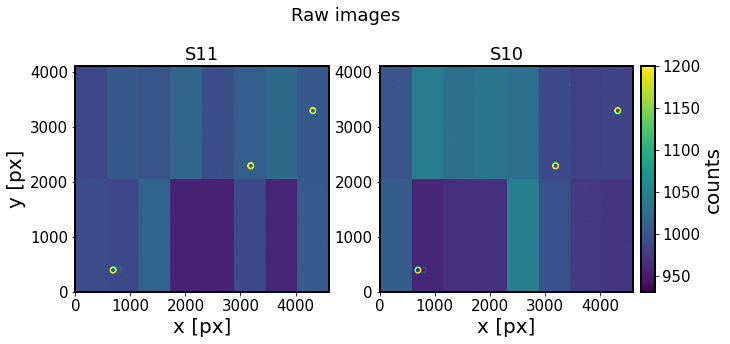

In [5]:
%matplotlib inline

fig,ax = plt.subplots(1,2,figsize=(10,5))

i = 0 
for sensor in raw_image.keys():
    im = ax[i].imshow(raw_image[sensor], origin='lower', vmax=1200)
    ax[i].set_title(sensor)
    ax[i].set_xlabel('x [px]')
    i += 1 
ax[0].set_ylabel('y [px]')

# dictionary with axis positions:
# x0, x1, y0, y1, width, height
pos = ax[1].get_position() 

# add colorbar axes: rectangle specified by 
# [left, bottom, width,height]
# in percentages of figure size 
cax = fig.add_axes([pos.x1+0.01,  # left 
                    pos.y0, # left 
                    0.02, # width
                    pos.height] # height
                  )
plt.colorbar(im, cax, label='counts')

fig.suptitle('Raw images', fontsize=18)

Do the ISR:

In [6]:
# do the ISR 
isrWrapper.config(doFlat=True, doOverscan=True)
isrWrapper.doISR(isrDir.name)

Read the post-ISR images with butler: 

In [7]:
%matplotlib inline

repoRoot = os.path.join(isrDir.name,'rerun/run1/') 
butler = dafPersist.Butler(repoRoot, )
ccd_image = {}
for sensor in ['S11','S10']:
    dataId = dict(run='9006001', visit=4021123106001, raftName='R22', detectorName=sensor)
    exposure = butler.get('postISRCCD', **dataId) 
    image = exposure.image.array
    ccd_image[sensor]=image
    


Show the post-ISR images:

Text(0.5, 0.98, 'Post-ISR images')

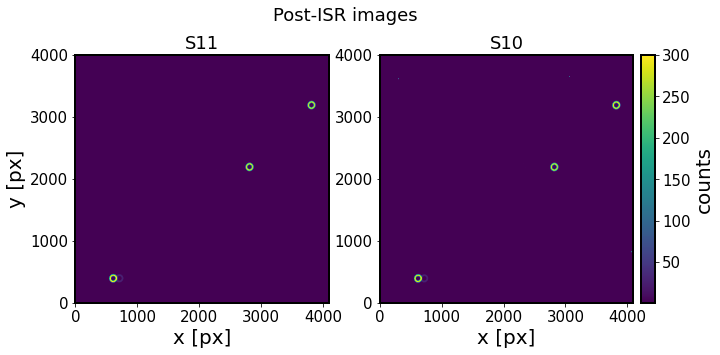

In [8]:
%matplotlib inline

fig,ax = plt.subplots(1,2,figsize=(10,5))

i = 0 
for sensor in ccd_image.keys():
    im = ax[i].imshow(ccd_image[sensor], origin='lower', vmin=1,vmax=300)
    ax[i].set_title(sensor)
    ax[i].set_xlabel('x [px]')
    i += 1 
    
pos = ax[1].get_position()
cax = fig.add_axes([pos.x1+0.01,  # left
                    pos.y0,  # bottom
                    0.02, # width
                    pos.height] # height
                  )
ax[0].set_ylabel('y [px]')
plt.colorbar(im, cax, label='counts')
fig.suptitle('Post-ISR images', fontsize=18)

In [9]:
# Remove all temporary directories
isrDir.cleanup()